<a href="https://colab.research.google.com/github/jaekim2172/-_Home/blob/main/kaggle_2021_MAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna
!pip install xgboost
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 4.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 14.0 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,StratifiedKFold
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/train.csv',index_col='id')
test=pd.read_csv('/content/drive/MyDrive/test.csv',index_col='id')

In [ ]:
print(train.shape,test.shape)

(300000, 31) (200000, 30)


In [ ]:
cat_features = [feature for feature in train.columns if 'cat' in feature]
cont_features = [feature for feature in train.columns if 'cont' in feature]

In [ ]:
train_cont=train[cont_features]
train_cont.columns[0]

'cont0'

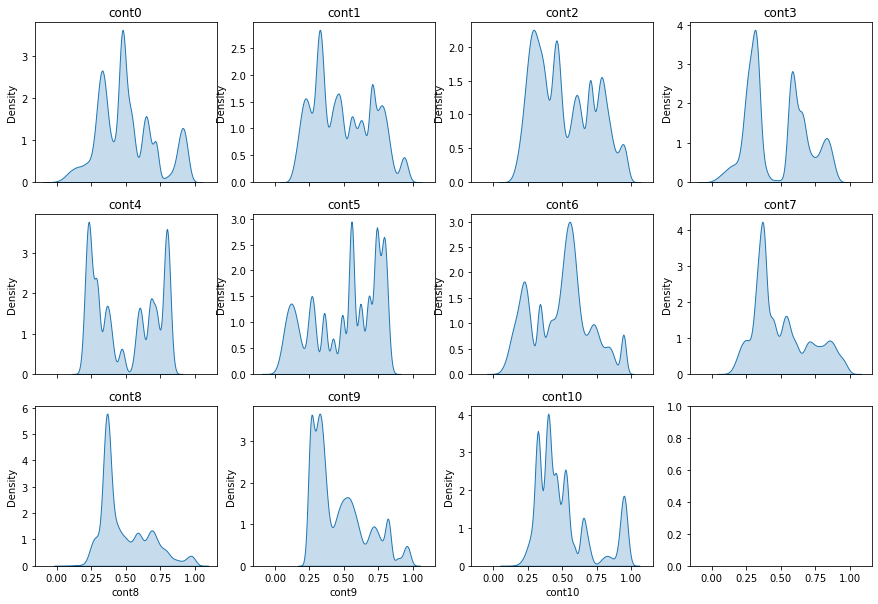

In [ ]:
train_cont=train[cont_features]
fig,axes=plt.subplots(3,4,figsize=(15,10),sharex=True)


for i, col in enumerate(train_cont.columns):
  sns.kdeplot(data=train_cont[col],ax=axes[i//4,i%4],shade=True)
  axes[i//4,i%4].set_title(col)


In [ ]:
train.describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.504749,0.494073,0.516632,0.474235,0.504848,0.502257,0.488229,0.501739,0.488074,0.469496,0.508230,0.264870
std,0.206788,0.213037,0.214851,0.216636,0.227474,0.241243,0.211335,0.203496,0.179048,0.194516,0.203393,0.441265
min,-0.049562,0.084480,0.094493,-0.045316,0.168071,-0.036379,0.005199,0.090901,0.024139,0.214866,0.097789,0.000000
25%,0.344985,0.317363,0.326047,0.292249,0.279303,0.276442,0.323914,0.353054,0.358915,0.309934,0.368312,0.000000
50%,0.479650,0.463170,0.471247,0.387564,0.479858,0.554768,0.518089,0.435404,0.410908,0.407477,0.446576,0.000000
75%,0.637657,0.693992,0.704625,0.644950,0.725779,0.735225,0.608537,0.642023,0.612725,0.586793,0.581957,1.000000
max,1.004559,1.009958,1.016600,0.952187,0.858578,0.853022,0.966553,1.035818,1.055885,1.005652,1.011331,1.000000


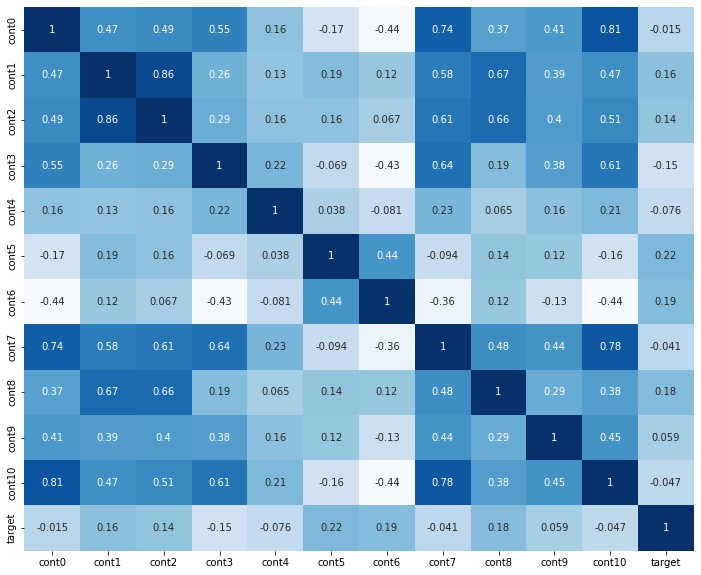

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(train.corr(),annot=True,cbar=False,cmap='Blues')
plt.show()

In [ ]:
train_cat=train[cat_features].copy()

for i in train_cat.columns:
  to12=train_cat[i].value_counts().index[:12]
  train_cat[i]=np.where(~(train_cat[i].isin(to12)),'Others',train_cat[i])

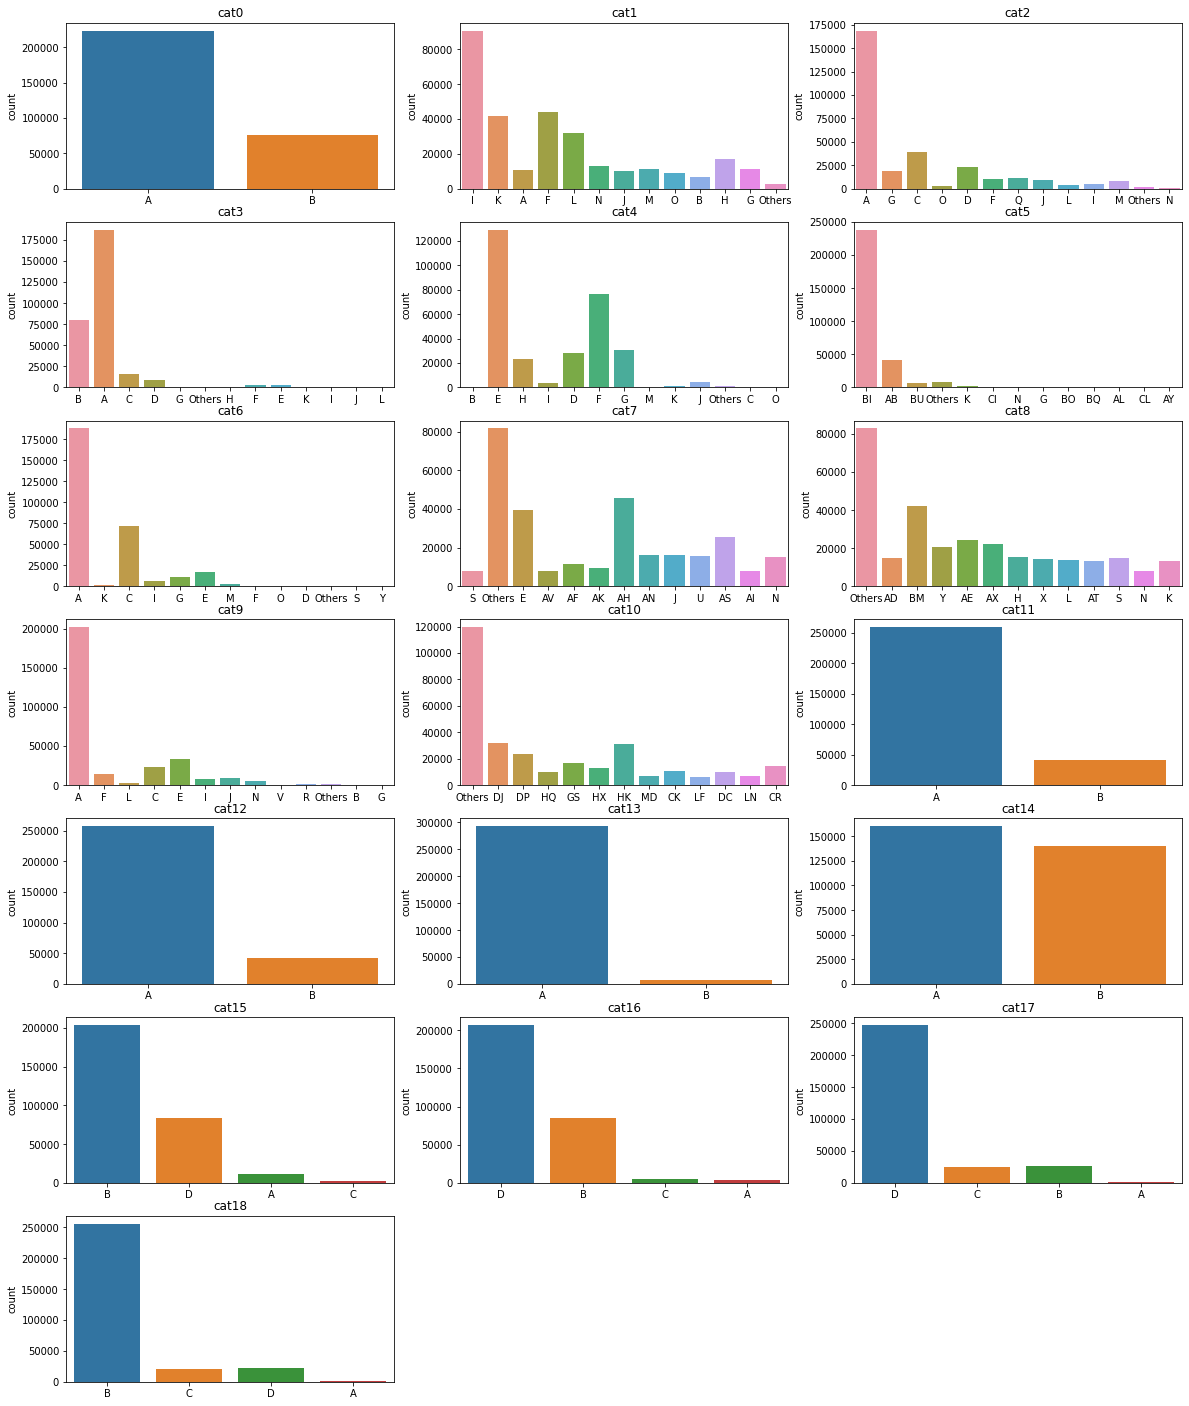

In [ ]:

fig,axes=plt.subplots(7,3,figsize=(20,25))


for i, col in enumerate(train_cat.columns):
  sns.countplot(x=train_cat[col].values,ax=axes[i//3,i%3])
  axes[i//3,i%3].set_title(col)
  axes[i//3,i%3].set_xlabel('')


axes[6,2].remove()
axes[6,1].remove()

In [ ]:
train_cat.shape

(300000, 19)

In [ ]:
train['target'].value_counts()/train['target'].value_counts().sum()

0    0.73513
1    0.26487
Name: target, dtype: float64

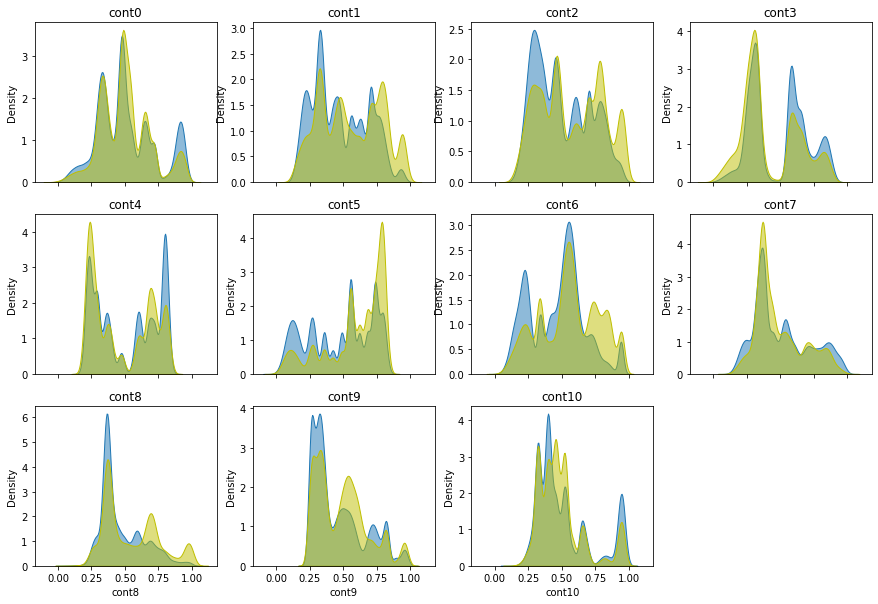

In [ ]:
train_cont=train[cont_features]
fig,axes=plt.subplots(3,4,figsize=(15,10),sharex=True)


for i, col in enumerate(train_cont.columns):
  sns.kdeplot(data=train.loc[train['target']==0,col],ax=axes[i//4,i%4],shade=True,alpha=0.5)
  sns.kdeplot(data=train.loc[train['target']==1,col],ax=axes[i//4,i%4],shade=True,alpha=0.5,color='y')
  axes[i//4,i%4].set_title(col)

axes[2,3].remove()

In [ ]:
combine=pd.concat([train,test])

le=LabelEncoder()

for i in cat_features:
  combine[i]=le.fit_transform(combine[i])

train_df=combine.iloc[:len(train)]
test_df=combine.iloc[len(train):]

In [ ]:
average_all_df = pd.DataFrame()
average_cat_df = pd.DataFrame()
average_cont_df = pd.DataFrame()

In [ ]:
X=train_df.drop('target',axis=1)
y=train_df['target']

kf=StratifiedKFold(n_splits=10)

In [ ]:
train_oof=np.zeros(300000)
i=0

for train_idx,valid_idx in kf.split(X,y):


  X_train=X.iloc[train_idx]
  X_val=X.iloc[valid_idx]
  y_train=y.iloc[train_idx]
  y_val=y.iloc[valid_idx]

  model=CatBoostClassifier(verbose=0,eval_metric="AUC",cat_features=[x for x in range(len(cat_features))],
                           task_type='GPU',devices='0')

  model.fit(X_train,y_train,eval_set=[(X_val, y_val)],early_stopping_rounds=30)
  temp_oof=model.predict_proba(X_val)[:,1]
  train_oof[valid_idx]=temp_oof
  print(i,'fold auc:',roc_auc_score(y_val,temp_oof))
  i=i+1

print('all features 300,000 auc',roc_auc_score(y,train_oof))
average_all_df['catboost'] = train_oof

Default metric period is 5 because AUC is/are not implemented for GPU


0 fold auc: 0.894320706210651


Default metric period is 5 because AUC is/are not implemented for GPU


1 fold auc: 0.8936173380438572


Default metric period is 5 because AUC is/are not implemented for GPU


2 fold auc: 0.8940749019790359


Default metric period is 5 because AUC is/are not implemented for GPU


3 fold auc: 0.8930402758750339


Default metric period is 5 because AUC is/are not implemented for GPU


4 fold auc: 0.8945470115900447


Default metric period is 5 because AUC is/are not implemented for GPU


5 fold auc: 0.8922178831078219


Default metric period is 5 because AUC is/are not implemented for GPU


6 fold auc: 0.889196125949552


Default metric period is 5 because AUC is/are not implemented for GPU


7 fold auc: 0.8918137484244277


Default metric period is 5 because AUC is/are not implemented for GPU


8 fold auc: 0.8944604508381151


Default metric period is 5 because AUC is/are not implemented for GPU


9 fold auc: 0.8896331407381822
all features 300,000 auc 0.8926892963802231


In [ ]:
train_oof = np.zeros((300000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(X,y)):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]

    X_train = train[cat_features]
    X_valid = valid[cat_features]
    y_train = train['target']
    y_valid = valid['target']

    model = CatBoostClassifier(verbose=0,
                                eval_metric="AUC",
                                random_state=42,
                                cat_features=[x for x in range(len(cat_features))],
                                task_type="GPU",
                                devices="0")

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))


print(f'OOF AUC - Categorical features only: ', roc_auc_score(train_df['target'], train_oof))
average_cat_df['catboost'] = train_oof

Default metric period is 5 because AUC is/are not implemented for GPU


Fold 0 AUC:  0.8886519670238971


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC:  0.887758047079873


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC:  0.887985499450574


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 AUC:  0.886576723070259


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 AUC:  0.8881967598420015


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 AUC:  0.8859685922737159


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 6 AUC:  0.8828079949562513


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 7 AUC:  0.8853791814024614


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 8 AUC:  0.888637338604913


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 9 AUC:  0.8839709803517318
OOF AUC - Categorical features only:  0.8865912313174048


In [ ]:
train_oof = np.zeros((300000,))

for fold, (train_idx, valid_idx) in enumerate(kf.split(X,y)):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]

    X_train = train[cont_features]
    X_valid = valid[cont_features]
    y_train = train['target']
    y_valid = valid['target']

    model = CatBoostClassifier(verbose=0,
                                eval_metric="AUC",
                                random_state=42,

                                task_type="GPU",
                                devices="0")

    model =  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    temp_oof = model.predict_proba(X_valid)[:,1]
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} AUC: ', roc_auc_score(y_valid, temp_oof))


print(f'OOF AUC - Categorical features only: ', roc_auc_score(train_df['target'], train_oof))
average_cont_df['catboost'] = train_oof

Default metric period is 5 because AUC is/are not implemented for GPU


Fold 0 AUC:  0.819307971183287


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 AUC:  0.81598389336601


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 AUC:  0.8136402020886837


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 AUC:  0.8161758118318876


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 AUC:  0.8154009992314359


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 AUC:  0.8149642466260937


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 6 AUC:  0.8127415657848818


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 7 AUC:  0.8146951202379005


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 8 AUC:  0.8137102712740582


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 9 AUC:  0.8111637389388371
OOF AUC - Categorical features only:  0.8147776034066583


In [ ]:
train_oof=np.zeros(300000)
i=0

for train_idx,valid_idx in kf.split(X,y):


  X_train=X.iloc[train_idx]
  X_val=X.iloc[valid_idx]
  y_train=y.iloc[train_idx]
  y_val=y.iloc[valid_idx]

  model=XGBClassifier(eval_metric="auc",tree_method='gpu_hist',gpu_id='0',use_label_encoder=False
                          )

  model.fit(X_train,y_train,eval_set=[(X_val, y_val)],verbose=0)
  temp_oof=model.predict_proba(X_val)[:,1]
  train_oof[valid_idx]=temp_oof
  print(i,'fold auc:',roc_auc_score(y_val,temp_oof))
  i=i+1

print('all features 300,000 auc',roc_auc_score(y,train_oof))
average_all_df['xgboost'] = train_oof

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


0 fold auc: 0.8915383706482892


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


1 fold auc: 0.8907895736367393


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


2 fold auc: 0.8912071326835663


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


3 fold auc: 0.889619673888801


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


4 fold auc: 0.8918398467564832


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


5 fold auc: 0.8896908158819652


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


6 fold auc: 0.8872589318153271


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


7 fold auc: 0.8889664509265419


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


8 fold auc: 0.8918529572665734


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


9 fold auc: 0.8868360795087662
all features 300,000 auc 0.8899598453953281


In [ ]:
train_oof=np.zeros(300000)
i=0

for train_idx,valid_idx in kf.split(X,y):
  X_cat=X[cat_features]

  X_train=X_cat.iloc[train_idx]
  X_val=X_cat.iloc[valid_idx]
  y_train=y.iloc[train_idx]
  y_val=y.iloc[valid_idx]

  model=XGBClassifier(eval_metric="auc",tree_method='gpu_hist',gpu_id='0',use_label_encoder=False
                          )

  model.fit(X_train,y_train,eval_set=[(X_val, y_val)],verbose=0)
  temp_oof=model.predict_proba(X_val)[:,1]
  train_oof[valid_idx]=temp_oof
  print(i,'fold auc:',roc_auc_score(y_val,temp_oof))
  i=i+1

print('categorical 300,000 auc',roc_auc_score(y,train_oof))
average_cat_df['xgboost'] = train_oof

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


0 fold auc: 0.8854184672813369


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


1 fold auc: 0.8845528454959797


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


2 fold auc: 0.8853689269577903


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


3 fold auc: 0.8836826214793329


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


4 fold auc: 0.8858497131871199


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


5 fold auc: 0.8841684236557222


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


6 fold auc: 0.8796943358328003


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


7 fold auc: 0.8828444989532249


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


8 fold auc: 0.8861205144108787


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


9 fold auc: 0.8813034188527974
categorical 300,000 auc 0.8838963679478442


In [ ]:
train_oof=np.zeros(300000)
i=0

for train_idx,valid_idx in kf.split(X,y):
  X_cont=X[cont_features]

  X_train=X_cont.iloc[train_idx]
  X_val=X_cont.iloc[valid_idx]
  y_train=y.iloc[train_idx]
  y_val=y.iloc[valid_idx]

  model=XGBClassifier(eval_metric="auc",tree_method='gpu_hist',gpu_id='0',use_label_encoder=False
                          )

  model.fit(X_train,y_train,eval_set=[(X_val, y_val)],verbose=0)
  temp_oof=model.predict_proba(X_val)[:,1]
  train_oof[valid_idx]=temp_oof
  print(i,'fold auc:',roc_auc_score(y_val,temp_oof))
  i=i+1

print('cont 300,000 auc',roc_auc_score(y,train_oof))
average_cont_df['xgboost'] = train_oof

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


0 fold auc: 0.8223907328717505


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


1 fold auc: 0.8199458609831471


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


2 fold auc: 0.817642405704361


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


3 fold auc: 0.8201168168989414


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


4 fold auc: 0.8190873066044261


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


5 fold auc: 0.8178779840234268


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


6 fold auc: 0.8152095458391481


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


7 fold auc: 0.8176617761620328


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


8 fold auc: 0.816851734950464


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


9 fold auc: 0.8166127672646226
cont 300,000 auc 0.8183448107826381


In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
train_oof=np.zeros(300000)
i=0

for train_idx,valid_idx in kf.split(X,y):


  X_train=X.iloc[train_idx]
  X_val=X.iloc[valid_idx]
  y_train=y.iloc[train_idx]
  y_val=y.iloc[valid_idx]

  model=LGBMClassifier(metric="auc",cat_feature=[x for x in range(len(cat_features))]
                          )

  model.fit(X_train,y_train,eval_set=[(X_val, y_val)],verbose=0)
  temp_oof=model.predict_proba(X_val)[:,1]
  train_oof[valid_idx]=temp_oof
  print(i,'fold auc:',roc_auc_score(y_val,temp_oof))
  i=i+1

print('all features 300,000 auc',roc_auc_score(y,train_oof))
average_all_df['lgbm'] = train_oof

0 fold auc: 0.8925341788002179
1 fold auc: 0.8932431991803931
2 fold auc: 0.8931820405767406
3 fold auc: 0.8919583007144603
4 fold auc: 0.893016614186203
5 fold auc: 0.8916668536471734
6 fold auc: 0.8874264153718657
7 fold auc: 0.890787955865418
8 fold auc: 0.8930533920915485
9 fold auc: 0.8889871627254682
all features 300,000 auc 0.8915830937994375


In [ ]:
train_oof=np.zeros(300000)
i=0

for train_idx,valid_idx in kf.split(X,y):
  X_cat=X[cat_features]


  X_train=X_cat.iloc[train_idx]
  X_val=X_cat.iloc[valid_idx]
  y_train=y.iloc[train_idx]
  y_val=y.iloc[valid_idx]

  model=LGBMClassifier(metric="auc",cat_feature=[x for x in range(len(cat_features))]
                          )

  model.fit(X_train,y_train,eval_set=[(X_val, y_val)],verbose=0)
  temp_oof=model.predict_proba(X_val)[:,1]
  train_oof[valid_idx]=temp_oof
  print(i,'fold auc:',roc_auc_score(y_val,temp_oof))
  i=i+1

print('cat features 300,000 auc',roc_auc_score(y,train_oof))
average_cat_df['lgbm'] = train_oof

0 fold auc: 0.8873078929367956
1 fold auc: 0.8872005151486051
2 fold auc: 0.8876465720789538
3 fold auc: 0.8862290534564373
4 fold auc: 0.8874091191994682
5 fold auc: 0.8862223969123588
6 fold auc: 0.8817394812508692
7 fold auc: 0.8844684246532053
8 fold auc: 0.8880096176533581
9 fold auc: 0.8839076840810952
cat features 300,000 auc 0.8860095434960682


In [ ]:
train_oof=np.zeros(300000)
i=0

for train_idx,valid_idx in kf.split(X,y):
  X_cont=X[cont_features]


  X_train=X_cont.iloc[train_idx]
  X_val=X_cont.iloc[valid_idx]
  y_train=y.iloc[train_idx]
  y_val=y.iloc[valid_idx]

  model=LGBMClassifier(metric="auc"
                          )

  model.fit(X_train,y_train,eval_set=[(X_val, y_val)],verbose=0)
  temp_oof=model.predict_proba(X_val)[:,1]
  train_oof[valid_idx]=temp_oof
  print(i,'fold auc:',roc_auc_score(y_val,temp_oof))
  i=i+1

print('cont features 300,000 auc',roc_auc_score(y,train_oof))
average_cont_df['lgbm'] = train_oof

0 fold auc: 0.8150470982021544
1 fold auc: 0.8112034304695354
2 fold auc: 0.8099464392721971
3 fold auc: 0.8117290349562092
4 fold auc: 0.810148241265159
5 fold auc: 0.8105421785681262
6 fold auc: 0.8079281739663285
7 fold auc: 0.8097524779063795
8 fold auc: 0.8076024284351037
9 fold auc: 0.8074570356092905
cont features 300,000 auc 0.8101256191606173


In [ ]:
average_all_df['average']=average_all_df.mean(axis=1)
average_cat_df['average']=average_cat_df.mean(axis=1)
average_cont_df['average']=average_cont_df.mean(axis=1)

print('전부다 평균',roc_auc_score(y,average_all_df['average']))
print('categorical 평균',roc_auc_score(y,average_cat_df['average']))
print('cont 평균',roc_auc_score(y,average_cont_df['average']))

전부다 평균 0.8939942292406803
categorical 평균 0.8874567492968295
cont 평균 0.818397716900022


In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 29355, done.
remote: Counting objects: 100% (3064/3064), done.
remote: Compressing objects: 100% (305/305), done.
remote: Total 29355 (delta 2893), reused 2825 (delta 2757), pack-reused 26291
Receiving objects: 100% (29355/29355), 20.35 MiB | 17.85 MiB/s, done.
Resolving deltas: 100% (21809/21809), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remot

In [ ]:
%cd /content/LightGBM

/content/LightGBM


In [ ]:
!mkdir build

In [ ]:
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)

CMake Warning:
  No source or binary directory provided.  Both will be assumed to be the
  same as the current working directory, but note that this warning will
  become a fatal error in future CMake releases.


-- The C compiler identification is GNU 9.4.0
-- The CXX compiler identification is GNU 9.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found ver

In [ ]:
!sudo apt-get -y install python-pip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package python-pip is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  python3-pip

E: Package 'python-pip' has no installation candidate


In [ ]:
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 79.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9

In [ ]:
%cd /content/LightGBM/python-package

/content/LightGBM/python-package


In [ ]:
!sudo python setup.py install — precompile

invalid command name '—'
